In [634]:
import geopandas as gpd
from matplotlib import pyplot as plt
import cartopy
import networkx as nx
import networkx.algorithms as algos
from functools import partial
from importlib import reload

import functions
reload(functions)

<module 'functions' from '/Users/hugoschwabe/Documents/Code/bachelor-thesis/functions.py'>

# Initialize and Process Full Graph

In [597]:
G = nx.read_gml("./data/de2025_simp.gml")

nodes = functions.graph_to_nodes_df(G)
nodes["x"] = nodes["coord"].map(lambda x: x[0])
nodes["y"] = nodes["coord"].map(lambda x: x[1])
nodes = gpd.GeoDataFrame(nodes)
nodes = nodes.set_geometry(gpd.points_from_xy(nodes["x"], nodes["y"]), crs="EPSG:3035").to_crs("EPSG:4326")

original = nx.Graph()
original.add_nodes_from(nodes.set_index("nodes").T.to_dict().items())
original.add_edges_from(G.edges(data=True))

In [610]:
original.nodes(data=True)

NodeDataView({'X_1693': {'coord': [4451976.104649, 3022833.492192], 'node_type': 'NO', 'x': 4451976.104649, 'y': 3022833.492192, 'geometry': <POINT (11.838 50.303)>}, 'DSO_1871': {'coord': [4454335.933506, 3018632.118088], 'node_type': 'NO', 'x': 4454335.933506, 'y': 3018632.118088, 'geometry': <POINT (11.87 50.265)>}, 'DSO_2165': {'coord': [4453548.157409, 3008771.494488], 'node_type': 'NO', 'x': 4453548.157409, 'y': 3008771.494488, 'geometry': <POINT (11.856 50.176)>}, 'DSO_1874': {'coord': [4456175.99051, 3012225.122382], 'node_type': 'NO', 'x': 4456175.99051, 'y': 3012225.122382, 'geometry': <POINT (11.894 50.207)>}, 'DSO_1870': {'coord': [4457384.46608, 3015160.098374], 'node_type': 'NO', 'x': 4457384.46608, 'y': 3015160.098374, 'geometry': <POINT (11.912 50.233)>}, 'DSO_1869': {'coord': [4457512.658531, 3015251.232525], 'node_type': 'NO', 'x': 4457512.658531, 'y': 3015251.232525, 'geometry': <POINT (11.913 50.233)>}, 'X_1695': {'coord': [4478892.919205, 2996175.444245], 'node_typ

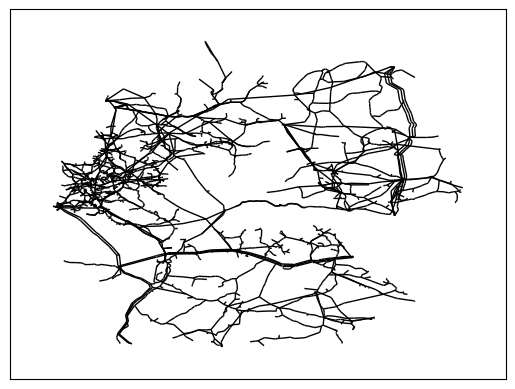

In [598]:
original_pos = {node: (data["coord"]) for node, data in original.nodes(data=True)}
nx.draw_networkx_edges(original, original_pos, arrows=False)

# Initialize NUTS Regions

In [599]:
nuts3 = gpd.read_file("./data//NUTS3/NUTS_RG_20M_2024_4326.shp").set_index("NUTS_ID")
nuts3 = nuts3[nuts3["LEVL_CODE"] == 3].to_crs("EPSG:4326")
nuts3 = nuts3.reset_index()
nuts3.head(3)

,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,geometry
0,AL011,3,AL,Dibër,Dibër,NaN,NaN,NaN,"POLYGON ((20.2208 41.86937, 20.56287 41.84614,..."
1,AL012,3,AL,Durrës,Durrës,NaN,NaN,NaN,"POLYGON ((19.55733 41.57767, 19.83218 41.56823..."
2,AL013,3,AL,Kukës,Kukës,NaN,NaN,NaN,"POLYGON ((20.59429 41.87733, 20.56287 41.84614..."


<GeoAxes: >

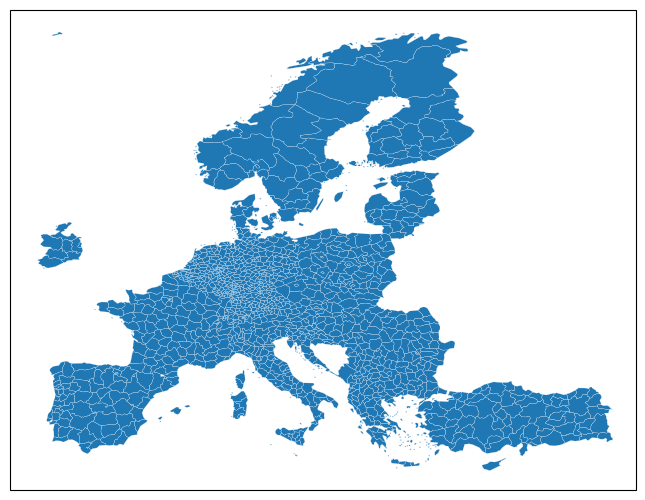

In [232]:
ax = plt.axes(
	[0, 0, 1, 1],
    projection=cartopy.crs.PlateCarree(),
	)

extent = [-13, 47, 33, 73]
ax.set_extent(extent, cartopy.crs.PlateCarree())

nuts3.plot(
	ax=ax,
	edgecolor='white',
	linewidth=0.15,

	)

# Run the Algorithms

In [240]:
from networkx.algorithms.community import greedy_modularity_communities, louvain_communities

# Visualization and Investigation

In [612]:
greedy_modularity_results = functions.run_algo(original, greedy_modularity_communities)

Gefundene Communities: 73
Modularität Q = 0.9597823559978254


In [613]:
greedy_modularity_graph = functions.build_results_graph(original, results=greedy_modularity_results)

In [615]:
functions.score(original, greedy_modularity_graph, nuts3, verbose=True)

nodes_score: 0.009245187436676799
edges_score: 0.017215482380127094
avg_degree_score: 1
complexity: 0.6578464433943987

structure: 0

original regions: 344
simplified regions: 62
regionality: 0.18023255813953487

original properties: 6022.75
simplified properties: 6022.75
properties: 1.0



0.5256286480537885

In [468]:
louvain_results = functions.run_algo(original, partial(louvain_communities, seed=42))

Gefundene Communities: 76
Modularität Q = 0.9598252413510922


In [469]:
louvain_graph = functions.build_results_graph(original, results=louvain_results)

In [569]:
functions.score(original, louvain_graph, nuts3, verbose=True)

nodes_score: 0.009625126646403243
edges_score: 0.018601964182553436
avg_degree_score: 1
complexity: 0.6572576363903477

structure: 0

original regions: 344
simplified regions: 64
regionality: 0.18604651162790697

original properties: 6022.75
simplified properties: 6022.75
properties: 1.0



0.526303236799825

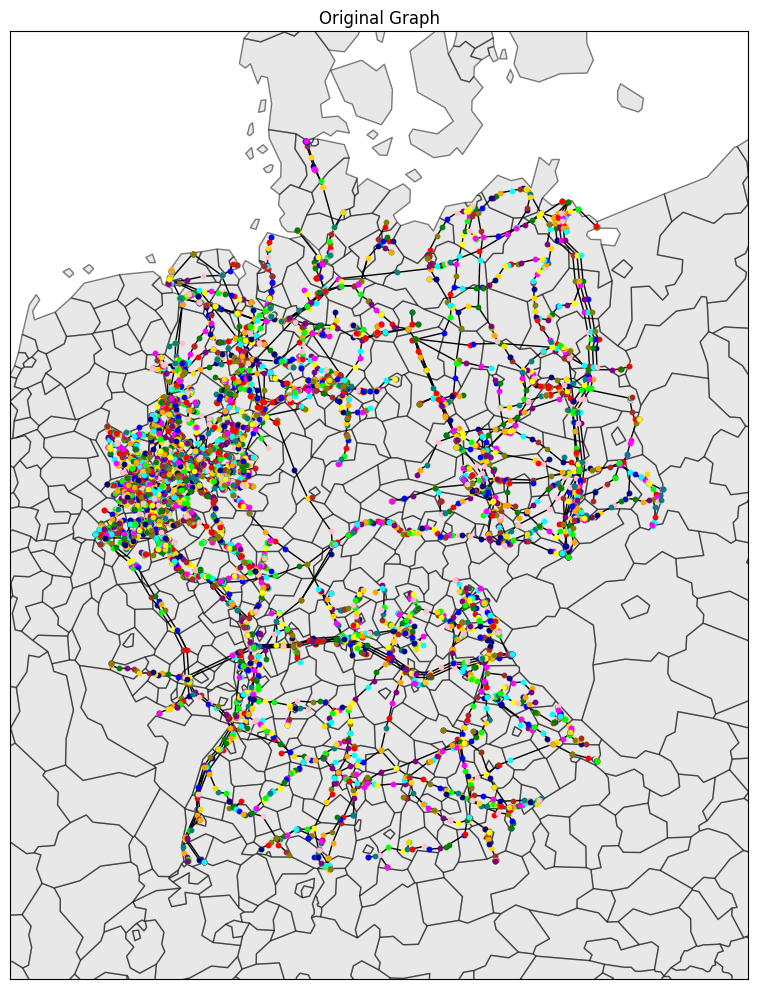

In [645]:
functions.plot_network(
	graph=original,
	gdf=nuts3.to_crs("EPSG:3035"),
	node_size=10, 
	title="Original Graph"
)

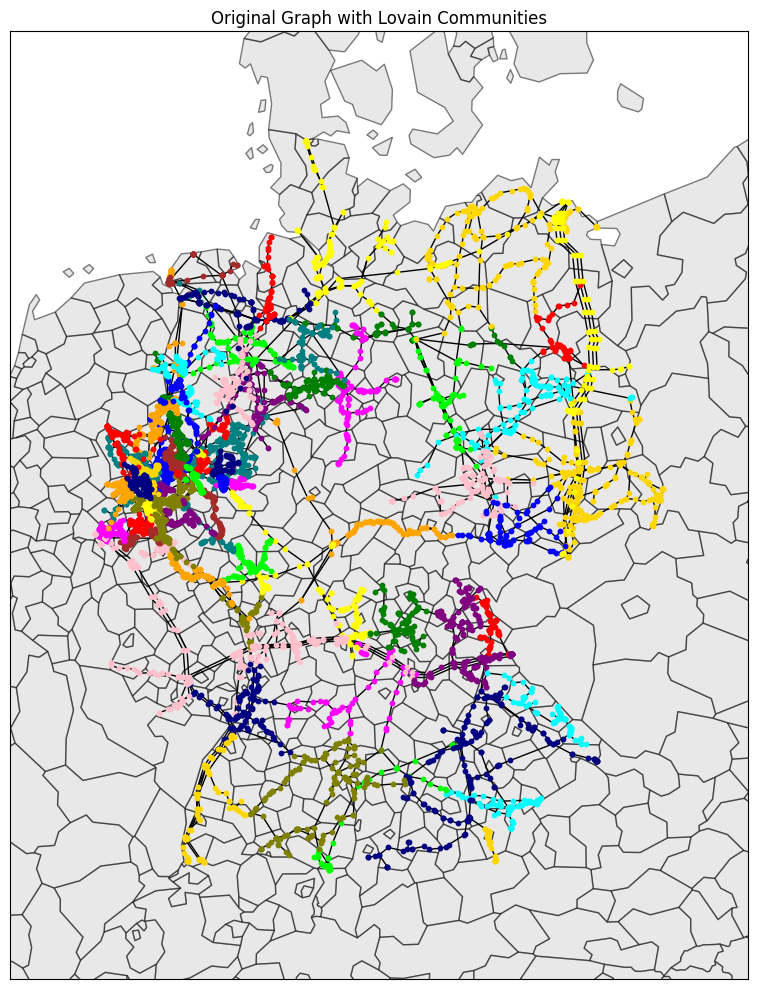

In [644]:
functions.plot_network(
	graph=original,
	gdf=nuts3.to_crs("EPSG:3035"),
	clusters=louvain_results,
	node_size=10, 
	title="Original Graph with Lovain Communities"
)

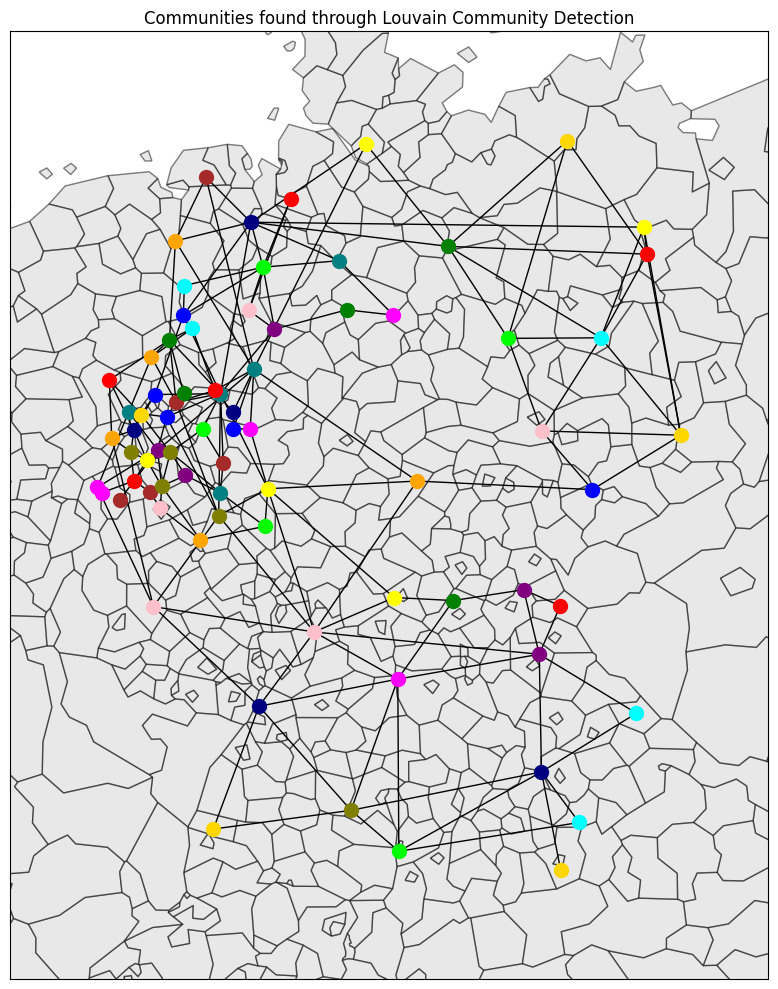

In [643]:
functions.plot_network(
	graph=louvain_graph,
	gdf=nuts3.to_crs("EPSG:3035"),
	node_size=100, 
	title="Communities found through Louvain Community Detection"
)

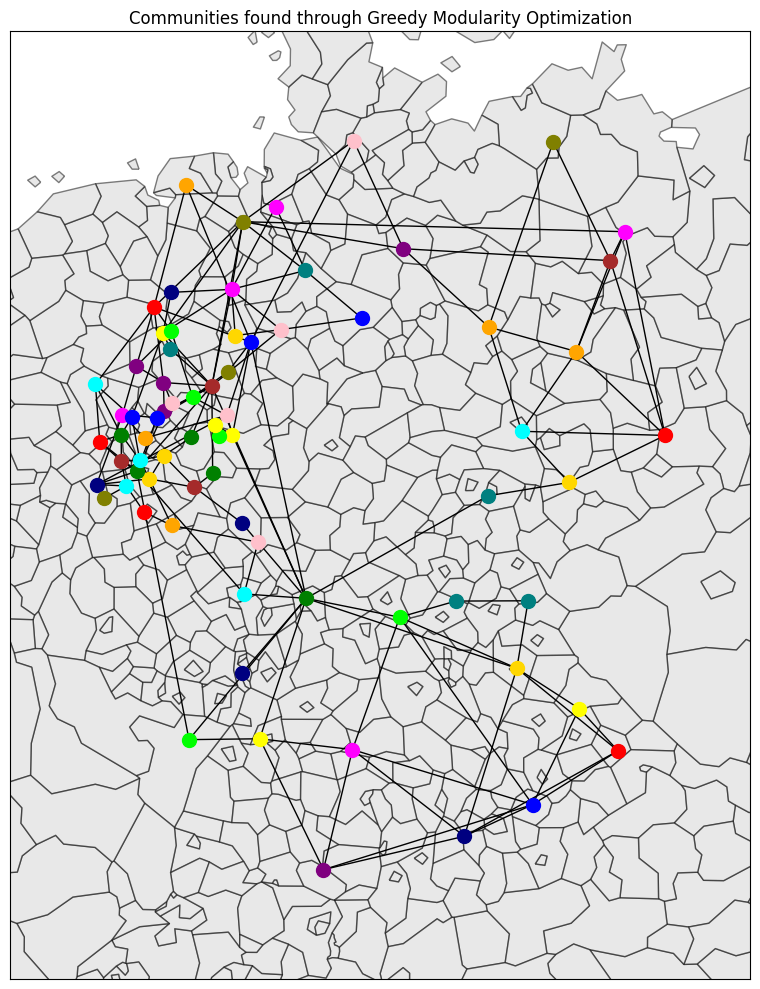

In [642]:
functions.plot_network(
	graph=greedy_modularity_graph,
	gdf=nuts3.to_crs("EPSG:3035"),
	node_size=100, 
	title="Communities found through Greedy Modularity Optimization"
)